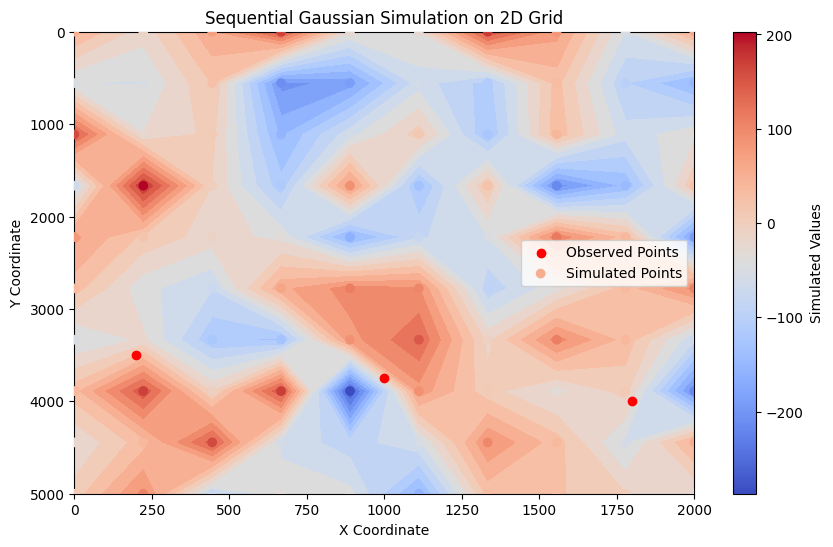

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Define the covariance function (e.g., Gaussian model)
def gaussian_covariance(h, range_param, sill):
    return sill * np.exp(-0.5 * (h / range_param) ** 2)

# Generate random 2D points for observed data
np.random.seed(42)
X_train = np.array([[200, 3500], [1000, 3750], [1800, 4000]])  # 3 observed points with (x, y) coordinates
y_train = np.array([0.9, 0.9, 0.9])  # Scalar values corresponding to observed points

# Create a 10x10 grid (100 prediction points)
x = np.linspace(0, 2000, 10)
y = np.linspace(0, 5000, 10)
X_grid, Y_grid = np.meshgrid(x, y)
grid_points = np.vstack([X_grid.ravel(), Y_grid.ravel()]).T  # Grid points to simulate

# Define covariance model parameters
range_param = 10.0      # Range of spatial correlation
sill = 12000.0              # Variance (sill)

# Sequential Gaussian Simulation (SGS)
num_simulations = 5
simulated_values = np.zeros(len(grid_points))  # Store simulated values for grid points

# Iteratively simulate each grid point
for i in range(len(grid_points)):
    # Combine observed data with simulated points up to the current point
    X_all = np.vstack([X_train, grid_points[:i + 1]])
    y_all = np.hstack([y_train, simulated_values[:i]])

    # Compute distance matrix for the current points
    distance_matrix = np.linalg.norm(X_all[:, np.newaxis] - X_all, axis=2)

    # Build covariance matrix using the distance matrix and covariance function
    cov_matrix = gaussian_covariance(distance_matrix, range_param, sill)

    # Split covariance matrix into submatrices
    cov_11 = cov_matrix[:len(y_all) - 1, :len(y_all) - 1]  # Covariance of known points
    cov_12 = cov_matrix[:len(y_all) - 1, len(y_all) - 1]   # Covariance between known and new point
    cov_22 = cov_matrix[len(y_all) - 1, len(y_all) - 1]    # Variance of the new point

    # Calculate conditional mean and variance for the new simulated value
    cov_11_inv = np.linalg.pinv(cov_11)  # Pseudo-inverse of cov_11
    mean = cov_12.T @ cov_11_inv @ y_all[:-1]  # Calculate the conditional mean
    #print (mean)
    variance = cov_22 - cov_12.T @ cov_11_inv @ cov_12  # Calculate the conditional variance
    #print (variance)

    # Ensure mean and variance are scalars
    mean = mean.item()  
    variance = variance.item() if np.isscalar(variance) else variance[0, 0]

    # Draw a random sample from the normal distribution
    simulated_values[i] = np.random.normal(mean, np.sqrt(max(variance, 0)))  # Ensure non-negative variance

# Plotting results
plt.figure(figsize=(10, 6))
plt.contourf(X_grid, Y_grid, simulated_values.reshape(X_grid.shape), cmap='coolwarm', levels=20)
plt.scatter(X_train[:, 0], X_train[:, 1], c='red', label='Observed Points', zorder=5)
plt.scatter(grid_points[:, 0], grid_points[:, 1], c=simulated_values, cmap='coolwarm', label='Simulated Points', zorder=3)
plt.gca().invert_yaxis()
plt.colorbar(label='Simulated Values')
plt.title('Sequential Gaussian Simulation on 2D Grid')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend()
plt.show()


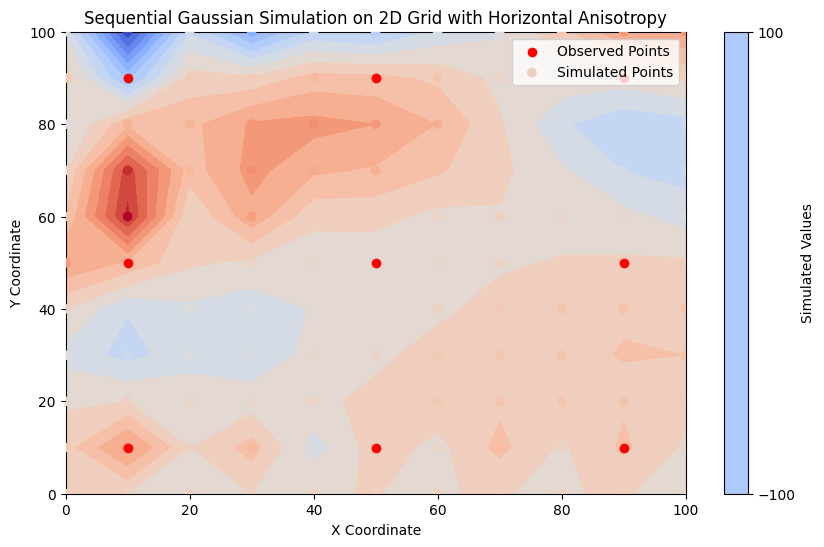

In [2]:
# Define the anisotropic Gaussian covariance function
def anisotropic_gaussian_covariance(h, range_param, sill, anisotropy_ratio, angle):
    # Rotation transformation to account for anisotropy and direction
    theta = np.deg2rad(angle)  # Convert angle to radians
    R = np.array([[np.cos(theta), -np.sin(theta)],
                  [np.sin(theta), np.cos(theta)]])
    # Scale the distances by the anisotropy ratio
    h_transformed = h @ R.T
    h_transformed[:, 0] /= anisotropy_ratio  # Apply the anisotropy scaling
    h_scaled = np.linalg.norm(h_transformed, axis=1)
    return sill * np.exp(-0.5 * (h_scaled / range_param) ** 2)

# Generate random 2D points for observed data
np.random.seed(42)
X_train = np.array([[10, 10], [50, 10], [90, 10],
                    [10, 50], [50, 50], [90, 50],
                    [10, 90], [50, 90], [90, 90]])  # 3 observed points with (x, y) coordinates
y_train = np.array([1, 1, 1,
                    1, 1, 1,
                    1, 1, 1])  # Scalar values corresponding to observed points

# Create a 10x10 grid (100 prediction points)
x = np.linspace(0, 100, 11)
y = np.linspace(0, 100, 11)
X_grid, Y_grid = np.meshgrid(x, y)
grid_points = np.vstack([X_grid.ravel(), Y_grid.ravel()]).T  # Grid points to simulate

# Define covariance model parameters
range_param = 100.0  # Range of spatial correlation
sill = 1.0          # Variance (sill)
anisotropy_ratio = 10.0  # Ratio of anisotropy (greater than 1 means stretched horizontally)
angle = 45  # Angle of anisotropy (0 degrees means stretching along x-axis)

# Sequential Gaussian Simulation (SGS)
num_simulations = 1
simulated_values = np.zeros(len(grid_points))  # Store simulated values for grid points

# Iteratively simulate each grid point
for i in range(len(grid_points)):
    # Combine observed data with simulated points up to the current point
    X_all = np.vstack([X_train, grid_points[:i + 1]])
    y_all = np.hstack([y_train, simulated_values[:i]])

    # Compute pairwise distance vectors between all points
    distance_vectors = X_all[:, np.newaxis] - X_all

    # Build covariance matrix using the distance vectors and anisotropic covariance function
    cov_matrix = anisotropic_gaussian_covariance(
        distance_vectors.reshape(-1, 2),
        range_param,
        sill,
        anisotropy_ratio,
        angle
    ).reshape(len(X_all), len(X_all))

    # Split covariance matrix into submatrices
    cov_11 = cov_matrix[:len(y_all) - 1, :len(y_all) - 1]  # Covariance of known points
    cov_12 = cov_matrix[:len(y_all) - 1, len(y_all) - 1]   # Covariance between known and new point
    cov_22 = cov_matrix[len(y_all) - 1, len(y_all) - 1]    # Variance of the new point

    # Calculate conditional mean and variance for the new simulated value
    cov_11_inv = np.linalg.pinv(cov_11)  # Pseudo-inverse of cov_11
    mean = cov_12.T @ cov_11_inv @ y_all[:-1]  # Calculate the conditional mean
    variance = cov_22 - cov_12.T @ cov_11_inv @ cov_12  # Calculate the conditional variance

    # Ensure mean and variance are scalars
    mean = mean.item()  
    variance = variance.item() if np.isscalar(variance) else variance[0, 0]

    # Draw a random sample from the normal distribution
    simulated_values[i] = np.random.normal(mean, np.sqrt(max(variance, 0)))  # Ensure non-negative variance

# Plotting results
plt.figure(figsize=(10, 6))
plt.contourf(X_grid, Y_grid, simulated_values.reshape(X_grid.shape), cmap='coolwarm', levels=20)
plt.scatter(X_train[:, 0], X_train[:, 1], c='red', label='Observed Points', zorder=5)
plt.scatter(grid_points[:, 0], grid_points[:, 1], c=simulated_values, cmap='coolwarm', label='Simulated Points', zorder=3)
plt.colorbar(label='Simulated Values', boundaries=[-100, 100])
plt.title('Sequential Gaussian Simulation on 2D Grid with Horizontal Anisotropy')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend()
plt.show()


#### GSTools Examples

### https://geostat-framework.readthedocs.io/projects/gstools/en/stable/examples/05_kriging/02_pykrige_interface.html#sphx-glr-examples-05-kriging-02-pykrige-interface-py

In [3]:
import numpy as np
from matplotlib import pyplot as plt
from pykrige.ok import OrdinaryKriging

import gstools as gs

# conditioning data
cond_x = [200, 1000, 1800]
cond_y = [3500, 3750, 4000]
cond_val = [0.9, 0.9, 0.9]

# grid definition for output field
gridx = np.arange(0.0, 2000.0, 2)
gridy = np.arange(0.0, 5000.0, 4)

In [4]:
model = gs.Gaussian(
    dim=2, len_scale=2500, anis=0.2, angles=0.2, var=1, nugget=0
)

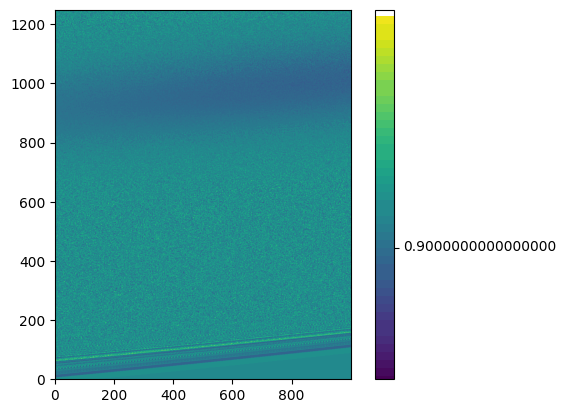

In [5]:
OK1 = OrdinaryKriging(cond_x, cond_y, cond_val, variogram_model=model)
z1, ss1 = OK1.execute("grid", gridx, gridy)
plt.imshow(z1, origin="lower")
plt.colorbar()
plt.show()

d:\Apps\Anaconda3\envs\gempy3\lib\site-packages\gstools\field\plot.py:401: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


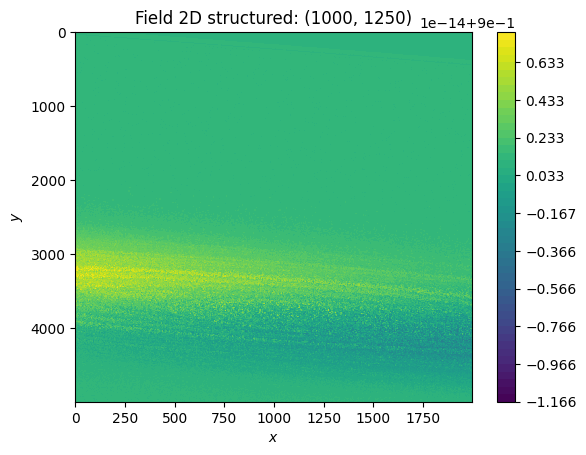

In [6]:
OK2 = gs.krige.Ordinary(model, [cond_x, cond_y], cond_val, exact=True)
OK2.structured([gridx, gridy])
ax = OK2.plot()
#ax.set_aspect("equal")
plt.gca().invert_yaxis()

<Axes: title={'center': 'Field 2D structured: (1000, 1250)'}, xlabel='$x$', ylabel='$y$'>

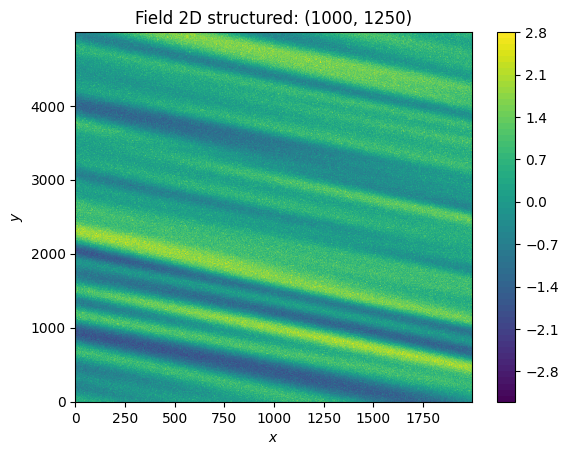

In [7]:
# Modified from Jan's code

# structured field with a size 100x100 and a grid-size of 1x1

# conditioning data
cond_x = [200, 1000, 1800]
cond_y = [3500, 1750, 4000]
cond_val = [0.9, 0.9, 0.9]

#x = y = range(100)
x = np.arange(0.0, 2000.0, 2)
y = np.arange(0.0, 5000.0, 4)

model = gs.Gaussian(dim=2, len_scale=2000, anis=0.05, angles=-0.5, var=0.5, nugget=0.1)
srf = gs.SRF(model)
srf((x, y), mesh_type='structured')
srf.plot()

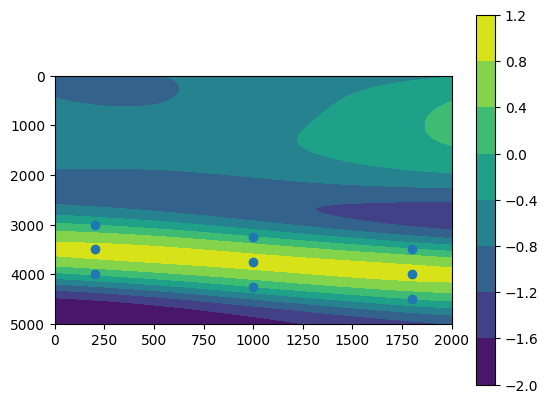

In [9]:
# conditioning data
cond_pos = [[200, 200, 200, 1000, 1000, 1000, 1800, 1800, 1800], [3000, 3500, 4000, 3250, 3750, 4250, 3500, 4000, 4500]]
cond_val = [0.0, 0.9, 0.0, 0.0, 0.9, 0.0, 0.0, 0.9, 0.0]
#cond_pos = [[200, 1000, 1800], [3500, 3750, 4000]]
#cond_val = [0.9, 0.9, 0.9]

#x = y = range(100)
x = np.arange(0.0, 2000.0, 100)
y = np.arange(0.0, 5000.0, 25)

model = gs.Gaussian(dim=2, var=0.5, len_scale=1700, anis=0.5, angles=-0.0)
krige = gs.Krige(model, cond_pos=cond_pos, cond_val=cond_val)
cond_srf = gs.CondSRF(krige)
cond_srf.set_pos([x, y], "structured")


seed = gs.random.MasterRNG(20170519)
ens_no = 4
for i in range(ens_no):
    cond_srf(seed=seed(), store=[f"fld{i}", False, False])

plt.contourf((cond_srf[0].T + cond_srf[1].T + cond_srf[2].T + cond_srf[3].T)/4, extent=[0, 2000, 0, 5000])
plt.gca().set_aspect(0.25)
plt.gca().invert_yaxis()
plt.colorbar()

plt.scatter(*cond_pos)
plt.show()

C:\Users\cco\AppData\Local\Temp\ipykernel_23108\3547712186.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


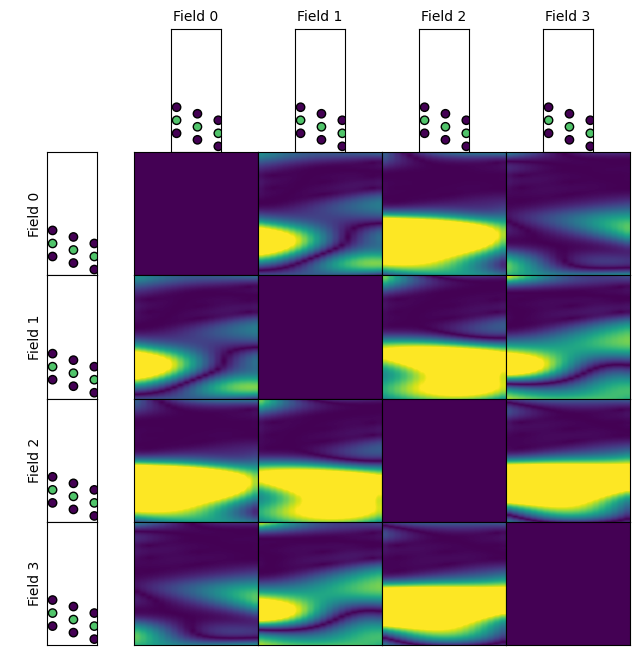

In [10]:
# Plots

seed = gs.random.MasterRNG(20170519)
ens_no = 4
for i in range(ens_no):
    cond_srf(seed=seed(), store=[f"fld{i}", False, False])


fig, ax = plt.subplots(ens_no + 1, ens_no + 1, figsize=(8, 8))
# plotting kwargs for scatter and image
vmax = np.max(cond_srf.all_fields)
sc_kw = dict(c=cond_val, edgecolors="k", vmin=0, vmax=vmax)
im_kw = dict(extent=[-1, 1, -1, 1], origin="lower", vmin=0, vmax=vmax)
for i in range(ens_no):
    # conditioned fields and conditions
    ax[i + 1, 0].imshow(cond_srf[i].T, **im_kw)
    ax[i + 1, 0].scatter(*cond_pos, **sc_kw)
    ax[i + 1, 0].set_ylabel(f"Field {i}", fontsize=10)
    ax[i + 1, 0].invert_yaxis()
    ax[0, i + 1].imshow(cond_srf[i].T, **im_kw)
    ax[0, i + 1].scatter(*cond_pos, **sc_kw)
    ax[0, i + 1].set_title(f"Field {i}", fontsize=10)
    ax[0, i + 1].invert_yaxis()
    # absolute differences
    for j in range(ens_no):
        ax[i + 1, j + 1].imshow(np.abs(cond_srf[i] - cond_srf[j]).T, **im_kw)

# beautify plots
ax[0, 0].axis("off")
for a in ax.flatten():
    a.set_xticklabels([]), a.set_yticklabels([])
    a.set_xticks([]), a.set_yticks([])
fig.subplots_adjust(wspace=0, hspace=0)
fig.show()